In [1]:
import os
import glob
import pandas as pd
import pickle
import numpy as np

from orion.primitives.tadgan import score_anomalies
from orion.primitives.timeseries_anomalies import find_anomalies
from orion.evaluation.contextual import contextual_f1_score, contextual_confusion_matrix, contextual_precision, contextual_recall
from orion.primitives.timeseries_errors import reconstruction_errors
from orion.primitives.timeseries_errors import regression_errors
from orion.primitives.aer import bi_regression_errors, score_anomalies
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler
from numpy import ndarray
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Constants and Helper Functions

## Create results from model predictions

In [2]:
PIPELINE_OUTPUT_DIRECTORY = '/Volumes/easystore/results'
CACHE_DIRECTORY = os.path.join(PIPELINE_OUTPUT_DIRECTORY, '{pipeline}/cache')
SCORES_DIRECTORY = os.path.join(os.getcwd(), 'scores')
RESULTS_DIRECTORY = os.path.join(os.getcwd(), 'results')
DATA_DIRECTORY = '/Users/lcwong/PycharmProjects/Orion/orion/data'

if not os.path.exists(SCORES_DIRECTORY): os.makedirs(SCORES_DIRECTORY)
if not os.path.exists(RESULTS_DIRECTORY): os.makedirs(RESULTS_DIRECTORY)

REGRESSION_PIPELINES = [
    'ARIMA',
    'ARIMA-UCR',
    'U_lstm_dynamic_threshold_2.0',
    'U_lstm_dynamic_threshold_2.0-UCR'
]

BI_REGRESSION_PIPELINES = [
    'U_bi_reg_250_2.0',
    'U_bi_reg_250_2.0-UCR'
]

RECONSTRUCTION_PIPELINES = [
    'U_lstm_autoencoder_2.0',
    'U_lstm_autoencoder_2.0-UCR',
    'U_vae_2.0',
    'U_vae_2.0-UCR'
]

TADGAN_PIPELINES = [
    'U_final_tadgan_2.0_gpu',
    'U_final_tadgan_2.0_gpu-UCR'
]

AER_PIPELINES = [
    'U_aer',
    'U_aer-UCR'
]

RESULTS_CSV_COLUMNS = [
    'dataset',
    'pipeline',
    'signal',
    'iteration',
    'f1',
    'recall',
    'precision',
    'tn',
    'fp',
    'fn',
    'tp',
    'status',
    'elapsed',
    'split',
    'run_id'
]

CODE_TO_PAPER_DATASET_MAP = {
    'MSL': 'MSL', 
    'SMAP': 'SMAP', 
    'YAHOOA1': 'A1', 
    'YAHOOA2': 'A2', 
    'YAHOOA3': 'A3', 
    'YAHOOA4': 'A4', 
    'artificialWithAnomaly': 'Art', 
    'realAdExchange': 'AdEx', 
    'realAWSCloudwatch': 'AWS', 
    'realTraffic': 'Traffic', 
    'realTweets': 'Tweets', 
    'UCR': 'UCR', 
}

TABLE_ORDER = [
    'MSL', 
    'SMAP', 
    'A1', 
    'A2', 
    'A3', 
    'A4', 
    'Art', 
    'AdEx', 
    'AWS', 
    'Traffic', 
    'Tweets', 
    'UCR', 
    'AVG (F1)', 
    'SD (F1)'
]

In [3]:
def retrieve_model_output(pipeline: str) -> pd.DataFrame:

    results = {
        # Required for results.csv
        'dataset': [],
        'pipeline': [],
        'signal': [],
        'iteration': [],
        'status': [],
        'elapsed': [],
        'split': [],
        'run_id': [],
        
        # Required to compute f1, recall, precision, tn, fp, fn, tp
        'expected': [],
        'index': [],
        'y': []
    }

    log_paths = glob.glob(os.path.join(PIPELINE_OUTPUT_DIRECTORY, pipeline, 'cache', '*.pkl'))
    
    for log_path in log_paths:
        results['pipeline'].append(pipeline)
        
        # Retrieve run metadata for the signal
        metadata = pd.read_csv(log_path[:-8] + '_scores.csv').iloc[0].to_dict()
        for col in ['dataset', 'signal', 'iteration', 'status', 'elapsed', 'split', 'run_id', 'expected']:
            results[col].append(metadata[col])
        
        # Read pipeline output for the signal
        with open(log_path, 'rb') as f:
            if pipeline in REGRESSION_PIPELINES + RECONSTRUCTION_PIPELINES:
                _, y, y_hat, index, _ = pickle.load(f)
                results.setdefault('y_hat', [])
                results['y_hat'].append(y_hat)
            
            elif pipeline in TADGAN_PIPELINES:
                _, y, _, _, index, errors, _ = pickle.load(f)  
                results.setdefault('errors', [])
                results['errors'].append(errors)
            
            elif pipeline in AER_PIPELINES:
                _, y, ry_hat, y_hat, fy_hat, index, _, _ = pickle.load(f)
                results.setdefault('y_hat', [])
                results['y_hat'].append(y_hat)
                results.setdefault('fy_hat', [])
                results['fy_hat'].append(fy_hat)
                results.setdefault('ry_hat', [])
                results['ry_hat'].append(ry_hat)
                
        results['index'].append(index)
        results['y'].append(y)
        
    return pd.DataFrame(results)

In [4]:
def mask_scores(anomaly_scores: ndarray) -> ndarray:
    num_hide_from_start = int(0.01 * len(anomaly_scores))
    anomaly_scores[:num_hide_from_start] = min(anomaly_scores)
    return anomaly_scores

def calculate_reconstruction_scores(y, y_hat, rec_error_type):
    anomaly_scores, _ = reconstruction_errors(y, y_hat, rec_error_type=rec_error_type, score_window=10)
    return anomaly_scores

def calculate_tadgan_scores(scores):
    return scores

def scores_wrapper(score_func: callable, params: list, pipeline: str, rec_type: str, processes: int = 10) -> pd.Series:
    """Load cache scores or process scores with multiple workers."""
    
    pipeline = pipeline + '_' + rec_type if rec_type else pipeline
    scores_path = os.path.join(SCORES_DIRECTORY, pipeline + '.pkl')
    
    if os.path.exists(scores_path):
        with open(scores_path, 'rb') as f:
            scores = pickle.load(f)
    
    else:        
        with Pool(processes=processes) as pool:
            scores = pool.starmap(score_func, params)
        
        with open(scores_path, 'wb') as f:
            pickle.dump(scores, f)
    
    return pd.Series(scores)


def add_anomaly_scores(results: pd.DataFrame, mask: bool = False, rec_type: str = '') -> pd.DataFrame:
    pipeline = results['pipeline'].iloc[0]

    if pipeline in REGRESSION_PIPELINES:
        columns = ['y', 'y_hat']
        score_func = regression_errors
        built_in_mask = False
    
    elif pipeline in RECONSTRUCTION_PIPELINES:
        columns = ['y', 'y_hat']
        score_func = calculate_reconstruction_scores
        built_in_mask = False
    
    elif pipeline in TADGAN_PIPELINES:
        columns = ['errors']
        score_func = calculate_tadgan_scores
        built_in_mask = False
    
    params = results[columns].copy()
    if rec_type:
        params['rec_type'] = rec_type
    params = params.to_records(index=False)
    scores = scores_wrapper(score_func, params, pipeline, rec_type)
    
    if not built_in_mask and mask:
        scores = [mask_scores(score) for score in scores]
    results['scores'] = scores

    return results

In [5]:
def add_statistics(results: pd.DataFrame) -> pd.DataFrame:
    statistics = ['f1', 'recall', 'precision', 'tn', 'fp', 'fn', 'tp']
    statistic_dict = {statistic: [] for statistic in statistics}

    for idx, row in results.iterrows():
            
        observed = find_anomalies(row['scores'], 
                                  row['index'],
                                  window_size_portion=0.33,
                                  window_step_size_portion= 0.1,
                                  fixed_threshold=True,
                                  min_percent=0.13,
                                 )
        observed = [(int(anomaly[0]), int(anomaly[1])) for anomaly in observed]
        expected = eval(row['expected'])

        tn, fp, fn, tp = contextual_confusion_matrix(expected, observed, weighted=False)
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
        values = [f1, recall, precision, tn, fp, fn, tp]
        for idx, statistic in enumerate(statistics):
            statistic_dict[statistic].append(values[idx])
    
    results = pd.concat([results, pd.DataFrame(statistic_dict)], axis=1)
    return results

## Create results from pipeline output

In [6]:
def load_results_from_output(pipeline: str) -> pd.DataFrame:
    directory = CACHE_DIRECTORY.format(pipeline=pipeline)
    return pd.concat([pd.read_csv(file) for file in glob.glob(directory + '/**.csv')])

## Helper functions for tables

In [7]:
def get_results(pipeline: str, mask: bool = False, use_pipeline_output: bool = False, rec_type: str = '') -> pd.DataFrame:
    if use_pipeline_output:
        results = load_results_from_output(pipeline)
    else:
        results = retrieve_model_output(pipeline)
        results = add_anomaly_scores(results, mask, rec_type)
        results = add_statistics(results)
    return results[RESULTS_CSV_COLUMNS]

def get_results_all_datasets(pipeline: str, mask: bool=False, use_pipeline_output: bool = False, rec_type: str = '') -> pd.DataFrame:
    non_ucr_results = get_results(pipeline, mask, use_pipeline_output, rec_type)
    ucr_results = get_results(pipeline + '-UCR', mask, use_pipeline_output, rec_type)
    return pd.concat([non_ucr_results, ucr_results])

def get_aggregate_f1_scores(results: pd.DataFrame, model_name: str, ndigits: int = 4) -> pd.DataFrame:
    
    output = {}
    f1_scores = []
    for idx, df in results.groupby('dataset'):
        cm = df[['tn', 'fp', 'fn', 'tp']].sum(axis=0)
        f1 = round(cm['tp'] / (cm['tp'] + .5 * (cm['fn'] + cm['fp'])), ndigits)
        output[CODE_TO_PAPER_DATASET_MAP[idx]] = f1
        f1_scores.append(f1)

    output['AVG (F1)'] = [round(np.mean(f1_scores), ndigits)]
    output['SD (F1)'] = [round(np.std(f1_scores), ndigits)]
    
    output = pd.DataFrame(output)
    ordered_column = [column for column in TABLE_ORDER if column in output.columns]
    output = output[ordered_column]
    output.index = [model_name]
    return output

In [8]:
def save(pipeline: str, results: pd.DataFrame, f1_scores: pd.DataFrame) -> None:
    results.to_csv(os.path.join(RESULTS_DIRECTORY, pipeline + '_results.csv'), index=False)
    f1_scores.to_csv(os.path.join(RESULTS_DIRECTORY, pipeline + '_f1_scores.csv'))
    
def load_f1_scores(pipeline: str) -> pd.DataFrame:
    return pd.read_csv(os.path.join(RESULTS_DIRECTORY, pipeline + '_f1_scores.csv'), index_col=0)

def load_results(pipeline: str) -> pd.DataFrame:
    return pd.read_csv(os.path.join(RESULTS_DIRECTORY, pipeline + '_results.csv'), index_col=0)

# Table IV Figure A

## ARIMA

Pipeline: `arima`

In [9]:
model_name = 'ARIMA'
pipeline = 'ARIMA'
mask = False
use_pipeline_output = True
rec_type = ''

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## ARIMA (M)*
Pipeline: `arima`

In [11]:
model_name = 'ARIMA (M)'
pipeline = 'ARIMA-M'
mask = True
use_pipeline_output = True
rec_type = ''

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## LSTM-NDT

Pipeline: `lstm_dynamic_threshold_viz`

In [15]:
model_name = 'LSTM-NDT'
pipeline = 'U_lstm_dynamic_threshold_2.0'
mask = False
use_pipeline_output = False
rec_type = ''

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

Proof that current post-processing is the same as output

In [16]:
model_name = 'LSTM-NDT'
pipeline = 'U_lstm_dynamic_threshold_2.0'
mask = False
use_pipeline_output = True
rec_type = ''

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
pipeline_f1_scores = get_aggregate_f1_scores(results, model_name)

assert(f1_scores.equals(pipeline_f1_scores))

## LSTM-NDT (M) *
Pipeline: `lstm_dynamic_threshold_viz`

In [17]:
model_name = 'LSTM-NDT (M)'
pipeline = 'U_lstm_dynamic_threshold_2.0'
mask = True
use_pipeline_output = False
rec_type = ''

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## LSTM-NDT (M, Bi)*
Pipeline: `bi_reg_250`

In [ ]:
results = calculate_results_for_all_datasets('U_bi_reg_250_2.0', True)
f1 = calculate_f1_for_all_datasets('LSTM-NDT (M, Bi)', results)
save_output('LSTM-NDT (M, Bi)', results, f1)

In [ ]:
create_summary('U_bi_reg_250_2.0-UCR')

## LSTM-AE
Pipeline: `lstm_autoencoder_viz`

In [9]:
model_name = 'LSTM-AE'
pipeline = 'U_lstm_autoencoder_2.0'
mask = False
use_pipeline_output = False
rec_type = 'dtw'

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## LSTM-AE (M)*
Pipeline: `lstm_autoencoder_viz`

In [10]:
model_name = 'LSTM-AE (M)'
pipeline = 'U_lstm_autoencoder_2.0'
mask = True
use_pipeline_output = False
rec_type = 'dtw'

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## LSTM-VAE
Pipeline: `vae_viz`

In [11]:
model_name = 'LSTM-VAE'
pipeline = 'U_vae_2.0'
mask = False
use_pipeline_output = False
rec_type = 'dtw'

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## LSTM-VAE (M)*
Pipeline: `vae_viz`

In [12]:
model_name = 'LSTM-VAE (M)'
pipeline = 'U_vae_2.0'
mask = True
use_pipeline_output = False
rec_type = 'dtw'

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## TadGAN
Pipeline: `tadgan_gpu`

In [27]:
model_name = 'TadGAN'
pipeline = 'U_final_tadgan_2.0_gpu'
mask = False
use_pipeline_output = False
rec_type = ''

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## TadGAN (M)*
Pipeline: `tadgan_gpu`

In [28]:
model_name = 'TadGAN (M)'
pipeline = 'U_final_tadgan_2.0_gpu'
mask = True
use_pipeline_output = False
rec_type = ''

results = get_results_all_datasets(pipeline, mask, use_pipeline_output, rec_type)
f1_scores = get_aggregate_f1_scores(results, model_name)
save(model_name, results, f1_scores)

## Complete Table

In [29]:
table_iv_pipelines = [
    'ARIMA',
    'ARIMA (M)',
    'LSTM-NDT',
    'LSTM-NDT (M)',
    'LSTM-AE',
    'LSTM-AE (M)',
    'LSTM-VAE',
    'LSTM-VAE (M)',
    'TadGAN',
    'TadGAN (M)'
]

pd.concat([load_f1_scores(pipeline) for pipeline in table_iv_pipelines])

,MSL,SMAP,A1,A2,A3,A4,Art,AdEx,AWS,Traffic,Tweets,UCR,AVG (F1),SD (F1)
ARIMA,0.4421,0.3333,0.7332,0.8074,0.8176,0.6998,0.3529,0.7407,0.5176,0.5000,0.5672,0.1236,0.5529,0.2068
ARIMA (M),0.4565,0.3590,0.7519,0.8093,0.8069,0.6899,0.5000,0.7692,0.5176,0.5000,0.5758,0.1481,0.5737,0.1933
LSTM-NDT,0.5155,0.7075,0.7206,0.9801,0.7442,0.6379,0.4000,0.7407,0.5128,0.6667,0.5797,0.3908,0.6330,0.1589
LSTM-NDT (M),0.5208,0.7536,0.7287,0.9875,0.7335,0.6378,0.6000,0.7692,0.5128,0.6857,0.5882,0.4461,0.6637,0.1398
LSTM-AE,0.4571,0.7259,0.6391,0.9610,0.5938,0.3678,0.4444,0.6429,0.6786,0.5926,0.5357,0.3292,0.5807,0.1652
LSTM-AE (M),0.4571,0.7717,0.6448,0.9633,0.5938,0.3670,0.4444,0.6429,0.6786,0.6154,0.5357,0.3333,0.5873,0.1693
LSTM-VAE,0.4324,0.6056,0.6171,0.9124,0.5977,0.3263,0.4444,0.7586,0.7018,0.5926,0.5357,0.3540,0.5732,0.1625
LSTM-VAE (M),0.4384,0.7049,0.6292,0.9406,0.5946,0.3279,0.4444,0.7586,0.7143,0.6154,0.5357,0.3607,0.5887,0.1709
TadGAN,0.5843,0.6174,0.5325,0.8421,0.3907,0.2969,0.5714,0.7200,0.6774,0.5806,0.5882,0.1625,0.5470,0.1777
TadGAN (M),0.5843,0.6301,0.5342,0.8462,0.3950,0.2913,0.6154,0.7200,0.6774,0.5806,0.5882,0.1642,0.5522,0.1796


# Table IV Figure B

Pipeline: `aer_viz`

In [44]:
def calculate_aer_reconstruction(y, y_hat):
    rec_scores, _ = reconstruction_errors(y[:, 1:-1], y_hat,
                                      smoothing_window=0.01,
                                      smooth=True,
                                      rec_error_type='dtw')
    rec_scores = mask_scores(rec_scores)
    rec_scores = np.concatenate([np.zeros(1), rec_scores, np.zeros(1)])
    return rec_scores

In [59]:
pipeline = 'U_aer'
results = retrieve_model_output(pipeline)

In [47]:
params = results[['y', 'ry_hat', 'fy_hat']]
params = params.to_records(index=False)
reg_scores = scores_wrapper(bi_regression_errors, params, pipeline + '_bi_reg', '')

In [49]:
params = results[['y', 'y_hat']].copy()
params = params.to_records(index=False)
rec_scores = scores_wrapper(calculate_aer_reconstruction, params, pipeline, 'dtw')

In [9]:
ucr_pipeline = 'U_bi_reg_ae_expand_weighted_loss_2.0-UCR'
ucr_summary = create_summary(ucr_pipeline)

In [12]:
ucr_params = ucr_summary[['y', 'ry_hat', 'fy_hat']]
ucr_params = ucr_params.to_records(index=False)
ucr_reg_scores = calculate_scores_wrapper(bi_regression_errors, ucr_params, ucr_pipeline + '_bi_reg')

In [73]:
ucr_params = ucr_summary[['y', 'y_hat']]
ucr_params = ucr_params.to_records(index=False)
ucr_rec_scores = np.array(calculate_scores_wrapper(calculate_aer_reconstruction, ucr_params, ucr_pipeline + '-UCR_dtw'))

## AER (PRED)*

In [60]:
non_ucr_results = results.copy()
non_ucr_results['scores'] = reg_scores
non_ucr_results = add_statistics(non_ucr_results)

# ucr_scores = ucr_reg_scores
# ucr_summary['scores'] = ucr_scores
# ucr_results = calculate_summary_from_scores(ucr_summary)

# results = pd.concat([non_ucr_results, ucr_results])
pred_results = non_ucr_results

In [61]:
f1_scores = get_aggregate_f1_scores(pred_results, 'AER (PRED)')
save('AER (PRED)', pred_results, f1_scores)

## AER (SUM)*

In [62]:
def sum_score(reg_scores, rec_scores, lambda_rec = 0.5):
    reg = MinMaxScaler([0, 1]).fit_transform(reg_scores.reshape(-1, 1)).flatten()
    rec = MinMaxScaler([0, 1]).fit_transform(rec_scores.reshape(-1, 1)).flatten()
    scores = (1 - lambda_rec) * reg + lambda_rec * rec
    return scores

In [64]:
non_ucr_results = results.copy()
scores = [sum_score(reg_score, rec_score) for reg_score, rec_score in zip(reg_scores, rec_scores)]
non_ucr_results['scores'] = scores
non_ucr_results = add_statistics(non_ucr_results)


# ucr_scores = [sum_score(reg_score, rec_score) for reg_score, rec_score in zip(ucr_reg_scores, ucr_rec_scores)]
# ucr_summary['scores'] = ucr_scores
# ucr_results = calculate_summary_from_scores(ucr_summary)

# results = pd.concat([non_ucr_results, ucr_results])
sum_results = non_ucr_results

In [65]:
f1_scores = get_aggregate_f1_scores(sum_results, 'AER (SUM)')
save('AER (SUM)', sum_results, f1_scores)

## AER (REC)*

In [68]:
non_ucr_results = results.copy()
non_ucr_results['scores'] = rec_scores
non_ucr_results = add_statistics(non_ucr_results)

# ucr_scores = ucr_rec_scores
# ucr_summary['scores'] = ucr_scores
# ucr_results = calculate_summary_from_scores(ucr_summary)

# results = pd.concat([non_ucr_results, ucr_results])
rec_results = non_ucr_results

In [69]:
f1_scores = get_aggregate_f1_scores(rec_results, 'AER (REC)')
save('AER (REC)', rec_results, f1_scores)

## AER (MULT)*

In [70]:
def mult_score(reg_scores, rec_scores, lambda_rec = 0.5):
    reg_scores = MinMaxScaler([1, 2]).fit_transform(reg_scores.reshape(-1, 1)).flatten()
    rec_scores = MinMaxScaler([1, 2]).fit_transform(rec_scores.reshape(-1, 1)).flatten()
    scores = np.multiply(reg_scores, rec_scores)
    return scores

In [73]:
non_ucr_results = results.copy()
scores = [mult_score(reg_score, rec_score) for reg_score, rec_score in zip(reg_scores, rec_scores)]
non_ucr_results['scores'] = scores
non_ucr_results = add_statistics(non_ucr_results)

# ucr_scores = [mult_score(reg_score, rec_score) for reg_score, rec_score in zip(ucr_reg_scores, ucr_rec_scores)]
# ucr_summary['scores'] = ucr_scores
# ucr_results = calculate_summary_from_scores(ucr_summary)

# results = pd.concat([non_ucr_results, ucr_results])
mult_results = non_ucr_results

In [74]:
f1_scores = get_aggregate_f1_scores(mult_results, 'AER (MULT)')
save('AER (MULT)', mult_results, f1_scores)

## Complete Table

In [75]:
table_iv_b_pipelines = [
    'AER (PRED)',
    'AER (SUM)',
    'AER (REC)',
    'AER (MULT)'
]

pd.concat([load_f1_scores(pipeline) for pipeline in table_iv_b_pipelines])

,MSL,SMAP,A1,A2,A3,A4,Art,AdEx,AWS,Traffic,Tweets,AVG (F1),SD (F1)
AER (PRED),0.4944,0.6846,0.7047,0.9227,0.8964,0.7222,0.5000,0.6875,0.5412,0.6154,0.5556,0.6659,0.1388
AER (SUM),0.4878,0.6803,0.7139,0.9359,0.7192,0.5532,0.5000,0.7333,0.7018,0.6061,0.5588,0.6537,0.1241
AER (REC),0.5000,0.6825,0.7072,0.9850,0.6203,0.4160,0.4444,0.6923,0.6441,0.5714,0.5185,0.6165,0.1507
AER (MULT),0.5405,0.7717,0.7723,0.9586,0.7525,0.5719,0.6154,0.6207,0.6349,0.6061,0.5846,0.6754,0.1187


# Table III

In [78]:
pipelines = [
    'ARIMA',
    'LSTM-NDT',
    'LSTM-AE',
    'LSTM-VAE',
    'TadGAN'
]
non_aer_f1 = pd.concat([load_f1_scores(pipeline) for pipeline in pipelines])


aer_pipelines = [
    'AER (PRED)',
    'AER (SUM)',
    'AER (REC)',
    'AER (MULT)'
]
aer_f1 = pd.concat([load_f1_scores(pipeline) for pipeline in aer_pipelines])
aer_f1 = aer_f1.max(axis=0)
aer_f1.Mean = np.mean(aer_f1[:12])
aer_f1.StDev = np.std(aer_f1[:12])
aer_f1 = pd.DataFrame(aer_f1).T
aer_f1.index = ['AER']

pd.concat([non_aer_f1, aer_f1])

,MSL,SMAP,A1,A2,A3,A4,Art,AdEx,AWS,Traffic,Tweets,UCR,AVG (F1),SD (F1)
ARIMA,0.4421,0.3333,0.7332,0.8074,0.8176,0.6998,0.3529,0.7407,0.5176,0.5000,0.5672,0.1236,0.5529,0.2068
LSTM-NDT,0.5155,0.7075,0.7206,0.9801,0.7442,0.6379,0.4000,0.7407,0.5128,0.6667,0.5797,0.3908,0.6330,0.1589
LSTM-AE,0.4571,0.7259,0.6391,0.9610,0.5938,0.3678,0.4444,0.6429,0.6786,0.5926,0.5357,0.3292,0.5807,0.1652
LSTM-VAE,0.4324,0.6056,0.6171,0.9124,0.5977,0.3263,0.4444,0.7586,0.7018,0.5926,0.5357,0.3540,0.5732,0.1625
TadGAN,0.5843,0.6174,0.5325,0.8421,0.3907,0.2969,0.5714,0.7200,0.6774,0.5806,0.5882,0.1625,0.5470,0.1777
AER,0.5405,0.7717,0.7723,0.9850,0.8964,0.7222,0.6154,0.7333,0.7018,0.6154,0.5846,NaN,0.6754,0.1507


# Figure 6

In [100]:
pipelines = [
    'ARIMA',
    'LSTM-NDT',
    'LSTM-AE',
    'LSTM-VAE',
    'TadGAN'
]
results = pd.concat([load_results(pipeline) for pipeline in pipelines])

signals = [
    '140-InternalBleeding4',
    '192-s20101mML2',
    '234-mit14157longtermecg'
]

time = dict()

for signal in signals:
    signal_results = results[results.signal == signal]
    for pipeline, seconds in zip(signal_results['pipeline'], signal_results['elapsed']):
        time.setdefault(pipeline, [])
        time[pipeline].append(round(seconds))

time = pd.DataFrame(time)
time.index = signals
time = time.T

time

,140-InternalBleeding4,192-s20101mML2,234-mit14157longtermecg
arima,3,484,1460
U_lstm_dynamic_threshold_2.0-UCR,14,117,139
U_lstm_autoencoder_2.0-UCR,14,85,160
U_vae_2.0-UCR,14,82,160
U_final_tadgan_2.0_gpu-UCR,91,1072,1762


# Figure 3 and 4

In [10]:
PREDICTION_BASED_MODELS = [
    'ARIMA', 
    'U_lstm_dynamic_threshold_2.0'
]

RECONSTRUCTION_BASED_MODELS = [
    'U_lstm_autoencoder_2.0',
    'U_vae_2.0'
]

REC_ERROR_TYPES = [
    'point',
    'area',
    'dtw'
]

PIPELINE_TO_NAME_MAP = {
    'ARIMA': 'ARIMA',
    'U_lstm_dynamic_threshold_2.0': 'LSTM-NDT',
    'U_lstm_autoencoder_2.0': 'LSTM-AE',
    'U_vae_2.0': 'LSTM-VAE'
}

PIPELINE_TO_COLOR_MAP = {
    'ARIMA': '#FAA31B',
    'U_lstm_dynamic_threshold_2.0': '#88C6ED',
    'U_lstm_autoencoder_2.0': '#82C341',
    'U_vae_2.0': '#D54799',
}

In [17]:
def get_predictions(model_name: str, signal_name: str) -> tuple:
    log_path_regex = os.path.join(PIPELINE_OUTPUT_DIRECTORY, model_name, 'cache', '**{}**.pkl'.format(signal_name))
    log_path = glob.glob(log_path_regex)[0]
    with open(log_path, 'rb') as f:
        _, y, y_hat, index, _ = pickle.load(f)
    return y, y_hat, index


def plot_figure(signal_name: str, dataset: str) -> None:
    fig, axs = plt.subplots(5, 1, figsize=(20, 25), sharex=True)

    all_anomalies = pd.read_csv(os.path.join(DATA_DIRECTORY, 'anomalies.csv'))

    # Graph (a): Signal and Anomalies
    signal = pd.read_csv(os.path.join(DATA_DIRECTORY, signal_name + '.csv'))
    axs[0].plot(signal['timestamp'], signal['value'], color='#050505')

    expected = eval(all_anomalies[all_anomalies.signal == signal_name].events.iloc[0])
    for start, end in expected:
        axs[0].axvspan(start-1, end+1, color='#FF0000', alpha=0.5)

    axs[0].set_title(f"Anomalies for {signal_name} from {dataset}", fontsize=24)


    # Graph (b): Prediction-based Anomaly Scores
    for model_name in PREDICTION_BASED_MODELS:
        y, y_hat, index = get_predictions(model_name, signal_name)
        errors = regression_errors(y, y_hat)
        axs[1].plot(index, errors, color=PIPELINE_TO_COLOR_MAP[model_name], label=PIPELINE_TO_NAME_MAP[model_name])

    axs[1].set_title("Prediction-based Anomaly Scores", fontsize=24)
    axs[1].legend(loc='upper right', ncol=len(PREDICTION_BASED_MODELS), prop={'size': 18})
    axs[1].axes.xaxis.set_ticklabels([])

    # Graph (c-e): Reconstruction-based Anomaly Scores
    for idx, rec_error_type in enumerate(REC_ERROR_TYPES):
        for model_name in RECONSTRUCTION_BASED_MODELS:
            y, y_hat, index = get_predictions(model_name, signal_name)
            errors, _ = reconstruction_errors(y, y_hat, rec_error_type = rec_error_type)
            axs[2+idx].plot(index[:-1], errors, color=PIPELINE_TO_COLOR_MAP[model_name], label=PIPELINE_TO_NAME_MAP[model_name])

        axs[2+idx].set_title(f"Reconstruction-based Anomaly Scores ({rec_error_type.upper()})", fontsize=24)
        axs[2+idx].legend(loc='upper right', ncol=len(RECONSTRUCTION_BASED_MODELS), prop={'size': 18})

    plt.rcParams.update({'font.size': 18})
    plt.show()                                  

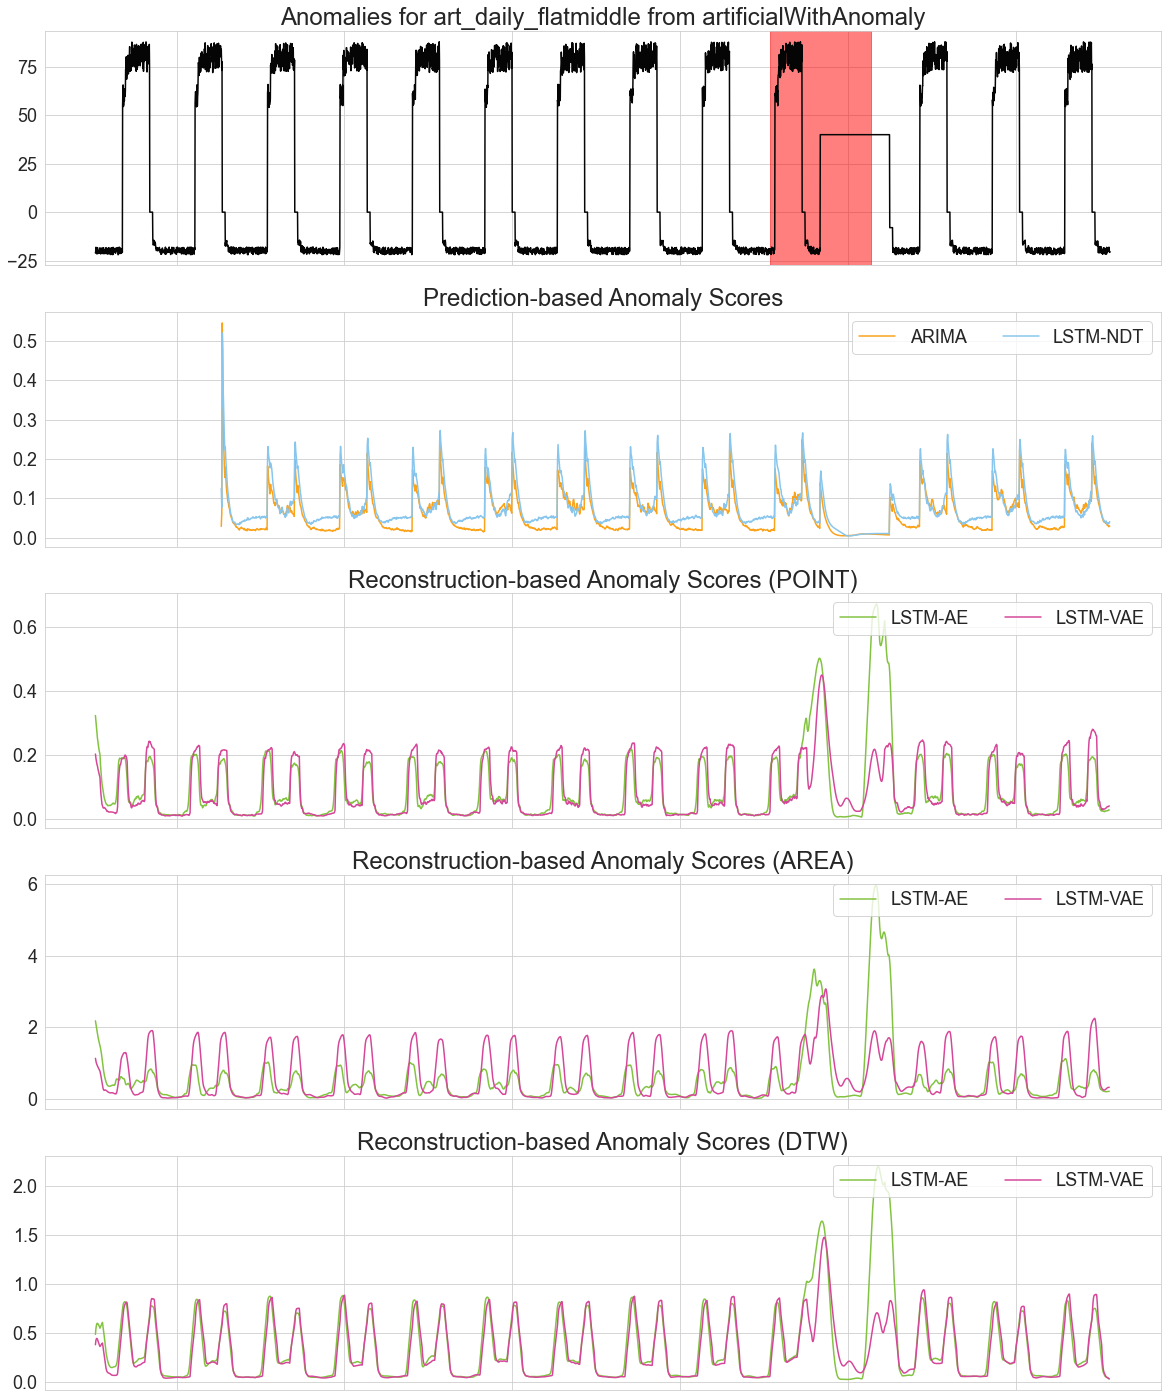

In [18]:
signal_name = 'art_daily_flatmiddle'
dataset = 'artificialWithAnomaly'

plot_figure(signal_name, dataset)

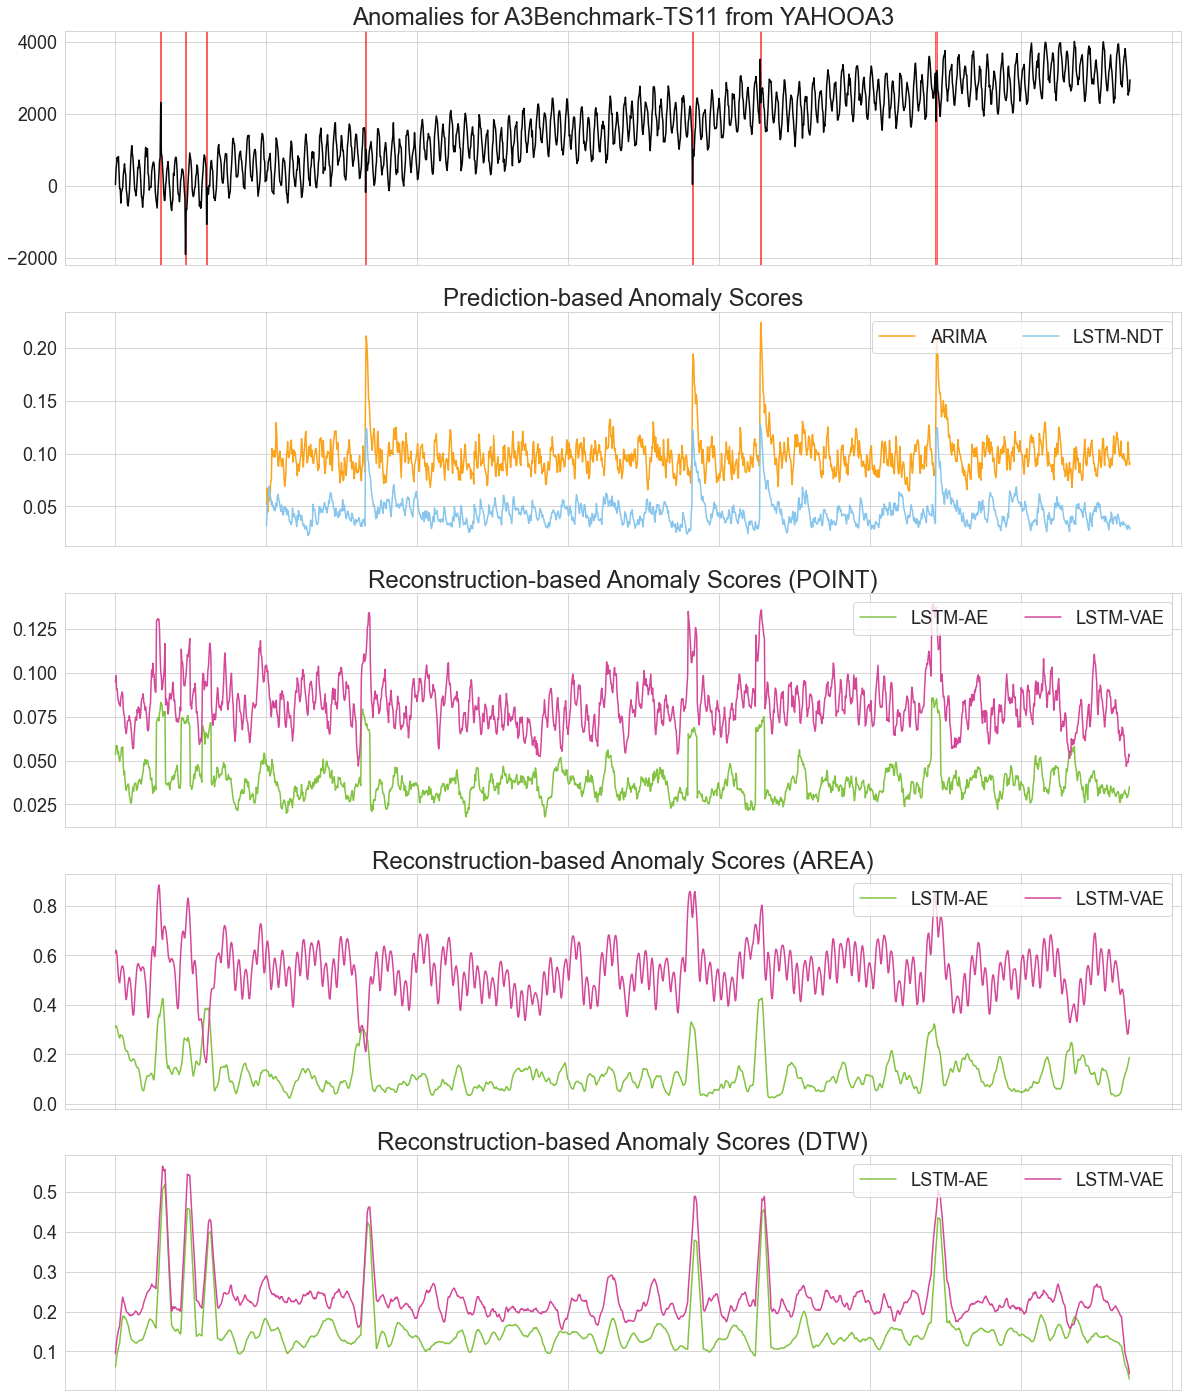

In [19]:
signal_name = 'A3Benchmark-TS11'
dataset = 'YAHOOA3'

plot_figure(signal_name, dataset)